In [ ]:
import os
import json
import numpy as np
import pandas as pd
from utils.eval import *
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
a = 45; b= 140
mode = "uni"
w_sec = 5; h_sec = w_sec/2


jdata1 = evaluation_single(a, b, mode, "anchor_zero", tolerance=0.13)    # overall acc1 per body segment
jdata2 = evaluation_single(a, b, mode, "anchor_peak", tolerance=0.13)    # overall acc1 per body segment
jdata3 = evaluation_single(a, b, mode, "anchor_energy",tolerance=0.13)    # overall acc1 per body segment

In [ ]:
a, b = 45, 140

accuracy_zero = evaluation_multi_segment("anchor_zero", "uni",a,b, tolerance=0.13)
accuracy_peak= evaluation_multi_segment("anchor_peak", "uni",a,b, tolerance=0.13)
accuracy_energy = evaluation_multi_segment("anchor_energy", "uni",a,b, tolerance=0.13)


## Evaluation: best of N strategy

In [2]:
a, b = 45, 140
mode = "uni"

segment_names = ["both_hand_y", "both_foot_y", "torso_y"]
json_data = eval_best_of_n(segment_names, a, b, mode, "anchor_zero")

chosen = json_data["chosen_candidated_bpm"]
print("Accuracy:", json_data["accuracy"])

Accuracy: 85.53318419090232


## Body Part Contribution per Dance Genre

In [6]:
with open("genre_symbols_mapping.json", "r") as file:
    genre_name = json.load(file)


output_path = f"./tempo_estimation_output/tempo_{a}_{b}/"
fpath4 = os.path.join(output_path, f"anchor_zero/left_hand_y_{mode}.pkl")
main_df = pd.read_pickle(fpath4)


# Assuming chosen and main_df have the same length
genre_part_map = defaultdict(list)

for i, (bpm, part) in enumerate(chosen):
    genre = main_df.loc[i, "dance_genre"]
    genre_part_map[genre_name[genre]].append(part)


# Convert to a DataFrame for easier counting
genre_part_df = pd.DataFrame([
    {"genre": genre, "body_part": part}
    for genre, parts in genre_part_map.items()
    for part in parts
])

# Count frequency of each body part per genre
part_counts = (
    genre_part_df.groupby(["genre", "body_part"])
    .size()
    .reset_index(name="count")
    .sort_values(["genre", "count"], ascending=[True, False])
    )

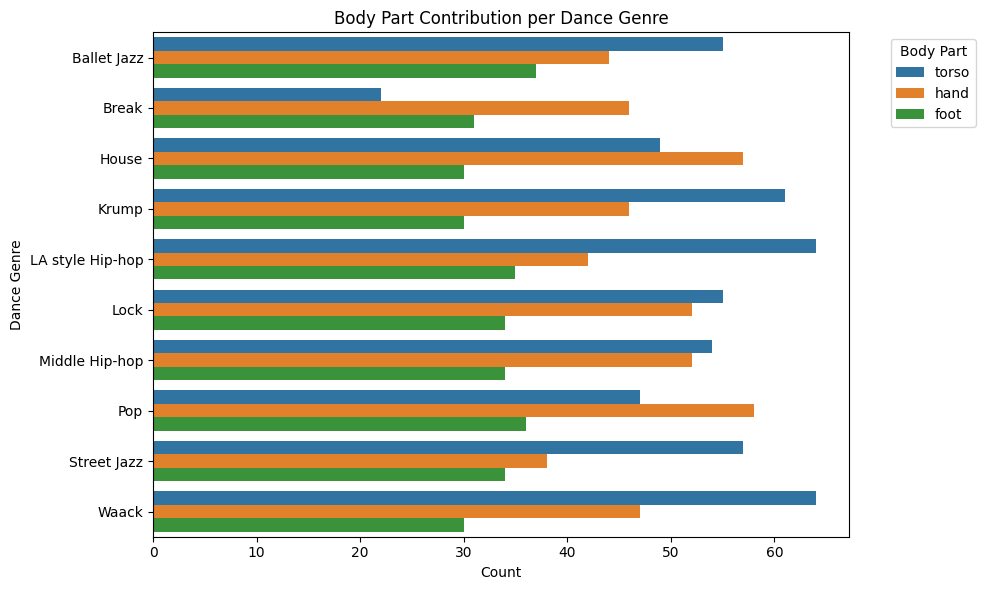

In [ ]:


plt.figure(figsize=(10, 6))
sns.barplot(
    data=part_counts,
    x="count",
    y="genre",
    hue="body_part",
    dodge=True
)

plt.title("Body Part Contribution per Dance Genre")
plt.xlabel("Count")
plt.ylabel("Dance Genre")
plt.legend(title="Body Part", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()
